# ESDA exercise with IMD data for Liverpool

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Data

Set the paths:

In [2]:
# This will be different on your computer and will depend on where
# you have downloaded the files
imd_shp = '../../../gds17_data/E08000012_IMD/shapefiles/E08000012.shp'

Read the data:

In [3]:
# Read the file in
imd = gpd.read_file(imd_shp)
# Index it on the LSOA ID
imd = imd.set_index('LSOA11CD')
# Display summary
imd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 298 entries, E01006512 to E01033768
Data columns (total 12 columns):
imd_rank      298 non-null int64
imd_score     298 non-null float64
income        298 non-null float64
employment    298 non-null float64
education     298 non-null float64
health        298 non-null float64
crime         298 non-null float64
housing       298 non-null float64
living_env    298 non-null float64
idaci         298 non-null float64
idaopi        298 non-null float64
geometry      298 non-null object
dtypes: float64(10), int64(1), object(1)
memory usage: 30.3+ KB


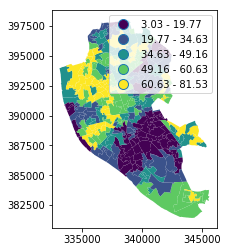

In [4]:
imd.plot(column='imd_score', scheme='quantiles', legend=True, linewidth=0)

Create contiguity weights and row-standardize them:

In [5]:
w = ps.queen_from_shapefile(imd_shp, idVariable='LSOA11CD')
w.transform = 'R'

Spatial lag of the scores:

In [6]:
imd['w_imd_score'] = ps.lag_spatial(w, imd['imd_score'])

Standardized version of IMD scores:

In [7]:
imd['imd_score_std'] = (imd['imd_score'] - imd['imd_score'].mean()) / imd['imd_score'].std()

Spatial lag of the standardized scores:

In [8]:
imd['w_imd_score_std'] = ps.lag_spatial(w, imd['imd_score_std'])

## Global spatial autocorrelation

* Moran Plot

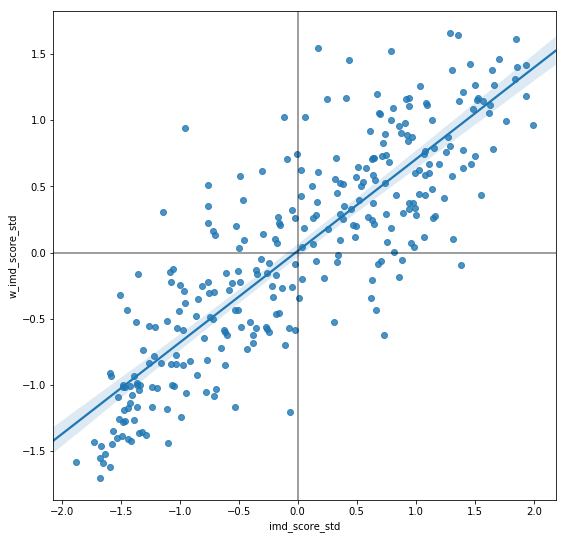

In [9]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='imd_score_std', y='w_imd_score_std', data=imd)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

* Moran's I

In [10]:
mi = ps.Moran(imd['imd_score'], w)

Statistic:

In [11]:
mi.I

0.6920071987390658

Inference on Moran's I:

In [12]:
mi.p_sim

0.001

## Local Spatial autocorrelation

* LISAs

In [13]:
lisa = ps.Moran_Local(imd['imd_score'].values, w)

Identifying quandrant and significant ones:

In [14]:
# Significant (p < 5%)
imd['significant'] = lisa.p_sim < 0.05
# Quadrants
imd['quadrant'] = lisa.q

* LISA cluster maps

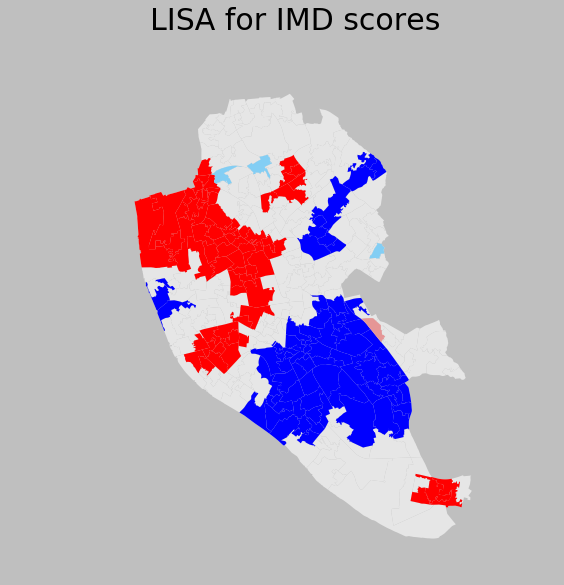

In [15]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot building blocks
imd.plot(ax=ax, facecolor='0.9', linewidth=0.1)
# Plot HH clusters
hh = imd.loc[(imd['quadrant']==1) & (imd['significant']==True), 'geometry']
# Note it fails if you attempt to plot an empty dataframe
if hh.shape[0] > 0:
    hh.plot(ax=ax, facecolor='red', linewidth=0)
# Plot LL clusters
ll = imd.loc[(imd['quadrant']==3) & (imd['significant']==True), 'geometry']
# Note it fails if you attempt to plot an empty dataframe
if ll.shape[0] > 0:
    ll.plot(ax=ax, facecolor='blue', linewidth=0)
# Plot LH clusters
lh = imd.loc[(imd['quadrant']==2) & (imd['significant']==True), 'geometry']
# Note it fails if you attempt to plot an empty dataframe
if lh.shape[0] > 0:
    lh.plot(ax=ax, facecolor='#83cef4', linewidth=0)
# Plot HL clusters
hl = imd.loc[(imd['quadrant']==4) & (imd['significant']==True), 'geometry']
# Note it fails if you attempt to plot an empty dataframe
if hl.shape[0] > 0:
    hl.plot(ax=ax, facecolor='#e59696', linewidth=0)
# Style and draw
f.suptitle('LISA for IMD scores', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.axis('equal')
plt.show()

---

<a rel="repo" href="https://github.com/darribas/gds18"><img alt="@darribas/gds18" style="border-width:0" src="../../GitHub-Mark.png" /></a>

This notebook, as well as the entire set of materials, code, and data included
in this course are available as an open Github repository available at: [`https://github.com/darribas/gds18`](https://github.com/darribas/gds18)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'18</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.